In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os

#  Load  and prepare HW and NO_HW df

##  Load HW data

In [2]:
# Load the parquet data from /Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet
#data_dir = '/Users/yguo/DataSpellProjects/hw/data/parquet'
data_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet'
file_name_hw = 'HW_1985_1994.parquet'
#join data_dir and file_name
hw_path = os.path.join(data_dir, file_name_hw)
df_hw = pd.read_parquet(hw_path)
print(df_hw.info())
df_hw

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20107224 entries, (-40.994766, 288.75, Timestamp('1985-12-01 00:00:00')) to (62.67016, 113.75, Timestamp('1994-07-15 23:00:00'))
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   UHI     float32
 1   UBWI    float32
 2   HW      float64
dtypes: float32(2), float64(1)
memory usage: 442.4 MB
None


UHI      UBWI   HW
lat        lon    time                                        
-40.994766 288.75 1985-12-01 00:00:00  1.284210 -0.116805  1.0
                  1985-12-01 01:00:00  1.196442  0.104045  1.0
                  1985-12-01 02:00:00  1.178253  0.174866  1.0
                  1985-12-01 03:00:00  1.142365  0.199996  1.0
                  1985-12-01 04:00:00  1.093079  0.209863  1.0
...                                         ...       ...  ...
 62.670158 113.75 1994-07-15 19:00:00  2.029236  1.313322  1.0
                  1994-07-15 20:00:00  1.745575  1.034362  1.0
                  1994-07-15 21:00:00  1.385864  0.682290  1.0
                  1994-07-15 22:00:00  0.643921  0.205750  1.0
                  1994-07-15 23:00:00  0.090027 -0.027581  1.0

[20107224 rows x 3 columns]

##  add hour, month and year to the df_hw


In [3]:
# Ensure 'time' is of datetime type
df_hw.index = df_hw.index.set_levels([df_hw.index.levels[0], df_hw.index.levels[1], pd.to_datetime(df_hw.index.levels[2])])

# Extract hour, month and year from 'time'
df_hw['hour'] = df_hw.index.get_level_values('time').hour
df_hw['month'] = df_hw.index.get_level_values('time').month
df_hw['year'] = df_hw.index.get_level_values('time').year
df_hw

UHI      UBWI   HW  hour  month  \
lat        lon    time                                                        
-40.994766 288.75 1985-12-01 00:00:00  1.284210 -0.116805  1.0     0     12   
                  1985-12-01 01:00:00  1.196442  0.104045  1.0     1     12   
                  1985-12-01 02:00:00  1.178253  0.174866  1.0     2     12   
                  1985-12-01 03:00:00  1.142365  0.199996  1.0     3     12   
                  1985-12-01 04:00:00  1.093079  0.209863  1.0     4     12   
...                                         ...       ...  ...   ...    ...   
 62.670158 113.75 1994-07-15 19:00:00  2.029236  1.313322  1.0    19      7   
                  1994-07-15 20:00:00  1.745575  1.034362  1.0    20      7   
                  1994-07-15 21:00:00  1.385864  0.682290  1.0    21      7   
                  1994-07-15 22:00:00  0.643921  0.205750  1.0    22      7   
                  1994-07-15 23:00:00  0.090027 -0.027581  1.0    23      7   

                                       year  
lat        lon    time                       
-40.994766 288.75 1985-12-01 00:00:00  1985  
                  1985-12-01 01:00:00  1985  
                  1985-12-01 02:00:00  1985  
                  1985-12-01 03:00:00  1985  
                  1985-12-01 04:00:00  1985  
...                                     ...  
 62.670158 113.75 1994-07-15 19:00:00  1994  
                  1994-07-15 20:00:00  1994  
                  1994-07-15 21:00:00  1994  
                  1994-07-15 22:00:00  1994  
                  1994-07-15 23:00:00  1994  

[20107224 rows x 6 columns]

In [4]:
# # Group by 'lat', 'lon', 'year', 'month', and 'hour', then calculate the mean of 'UHI' and 'UBWI'
# df_hw_avg = df_hw.groupby(['lat', 'lon', 'year', 'month', 'hour']).mean()
# df_hw_avg

##  Load NO_HW data

In [5]:

file_name_no_hw = 'NO_HW_1985_1994.parquet'
#join data_dir and file_name
no_hw_path = os.path.join(data_dir, file_name_no_hw)
df_no_hw = pd.read_parquet(no_hw_path)
print(df_no_hw.info())
df_no_hw

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73117416 entries, (-55.13089, 291.25, Timestamp('1985-01-01 00:00:00')) to (70.20943, 31.25, Timestamp('1994-08-31 23:00:00'))
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   UHI     float32
 1   UBWI    float32
dtypes: float32(2)
memory usage: 1.1 GB
None


UHI      UBWI
lat        lon    time                                   
-55.130890 291.25 1985-01-01 00:00:00 -0.465027 -0.488769
                  1985-01-01 01:00:00  0.007538  0.027193
                  1985-01-01 02:00:00  0.213013  0.172712
                  1985-01-01 03:00:00  0.209503  0.155361
                  1985-01-01 04:00:00  0.164490  0.133307
...                                         ...       ...
 70.209427 31.25  1994-08-31 19:00:00  0.879242  0.335660
                  1994-08-31 20:00:00  1.104370  0.431603
                  1994-08-31 21:00:00  1.207367  0.512312
                  1994-08-31 22:00:00  1.184082  0.508102
                  1994-08-31 23:00:00  1.111176  0.470229

[73117416 rows x 2 columns]

In [6]:
#todo: add UHI and NO_HW UHI to make sure they are the same as the oringal netcdf data


##  Validate there is not overlap between the HW and NO_HW data

In [7]:
#the key for both df_hw and df_no_hw are lat, lon and time. please show python code that they don't overlap on those keys
# Convert the MultiIndex of both DataFrames to sets
# keys_hw = set(df_hw.index)
# keys_no_hw = set(df_no_hw.index)
# 
# # Check if the intersection of these sets is empty
# overlap = keys_hw & keys_no_hw
# 
# # If the intersection is empty, print that there is no overlap. Otherwise, print the overlapping keys.
# if not overlap:
#     print("There is no overlap between the keys of df_hw and df_no_hw.")
# else:
#     print("The following keys overlap between df_hw and df_no_hw:")
#     print(overlap)

In [8]:

# group df_no_hw by lat, lon, year and hour of the day avaerage UHI and UBWI
df_no_hw.index = df_no_hw.index.set_levels(
    [df_no_hw.index.levels[0], df_no_hw.index.levels[1], pd.to_datetime(df_no_hw.index.levels[2])])
df_no_hw['hour'] = df_no_hw.index.get_level_values('time').hour
df_no_hw['year'] = df_no_hw.index.get_level_values('time').year
df_no_hw_avg = df_no_hw.groupby(['lat', 'lon', 'year', 'hour']).mean()
df_no_hw_avg

UHI      UBWI
lat        lon    year hour                    
-55.130890 291.25 1985 0     0.305542  0.122376
                       1     0.366234  0.171864
                       2     0.374915  0.186239
                       3     0.351239  0.173043
                       4     0.331068  0.164803
...                               ...       ...
 70.209427 31.25  1994 19    0.677809  0.283742
                       20    0.815796  0.349291
                       21    0.902967  0.396645
                       22    0.955209  0.448562
                       23    0.972885  0.492617

[1002504 rows x 2 columns]

#  2: Calculate the difference between UHI in df_hw and df_no_hw

##  UHI HW - NO_HW ( HW hour data - NO_HW yearl average data for the hour) 
the df_no_hw_avg is the average value for a given hour of the day throughout the year.
In the 2018 Zhao paper they seem to just do average the whole 30 years. 
I want to substract the average UHI on the given hour for a given year from the hourly UHI data I have in df_hw, matching the year and hour between the two dataframes.


##  Step 2.1: Reset the index of df_hw and df_no_hw_avg (be careful on the increased memory usage)

In [9]:
df_hw.info()
df_hw_reset = df_hw.reset_index()
df_hw_reset.info()
df_no_hw_avg.info()
df_no_hw_avg_reset = df_no_hw_avg.reset_index()
df_no_hw_avg_reset.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20107224 entries, (-40.994766, 288.75, Timestamp('1985-12-01 00:00:00')) to (62.67016, 113.75, Timestamp('1994-07-15 23:00:00'))
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   UHI     float32
 1   UBWI    float32
 2   HW      float64
 3   hour    int32  
 4   month   int32  
 5   year    int32  
dtypes: float32(2), float64(1), int32(3)
memory usage: 672.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20107224 entries, 0 to 20107223
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   lat     float32       
 1   lon     float32       
 2   time    datetime64[ns]
 3   UHI     float32       
 4   UBWI    float32       
 5   HW      float64       
 6   hour    int32         
 7   month   int32         
 8   year    int32         
dtypes: datetime64[ns](1), float32(4), float64(1), int32(3)
memory usage: 843.7 MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10


##   Step 2.2: Merge df_hw with df_no_hw_avg_reset

In [10]:

merged_df = pd.merge(df_hw_reset, df_no_hw_avg_reset[['lat', 'lon', 'year', 'hour', 'UHI', 'UBWI']],
                     on=['lat', 'lon', 'year', 'hour'],
                     suffixes=('', '_avg'))

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18740520 entries, 0 to 18740519
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   lat       float32       
 1   lon       float32       
 2   time      datetime64[ns]
 3   UHI       float32       
 4   UBWI      float32       
 5   HW        float64       
 6   hour      int32         
 7   month     int32         
 8   year      int32         
 9   UHI_avg   float32       
 10  UBWI_avg  float32       
dtypes: datetime64[ns](1), float32(6), float64(1), int32(3)
memory usage: 929.4 MB



##  Step 2.3: Subtract the average UHI from the hourly UHI and store in a new column

In [12]:

merged_df['UHI_diff'] = merged_df['UHI'] - merged_df['UHI_avg']
merged_df['UBWI_diff'] = merged_df['UBWI'] - merged_df['UBWI_avg']
# Now, merged_df contains your original data along with the subtracted UHI values in 'UHI_diff'
merged_df  # To check the first few rows of the merged DataFrame

,lat,lon,time,UHI,UBWI,HW,hour,month,year,UHI_avg,UBWI_avg,UHI_diff,UBWI_diff
0,-40.994766,288.75,1985-12-01 00:00:00,1.284210,-0.116805,1.0,0,12,1985,0.949050,0.060714,0.335160,-0.177519
1,-40.994766,288.75,1985-12-01 01:00:00,1.196442,0.104045,1.0,1,12,1985,0.949663,0.218916,0.246778,-0.114871
2,-40.994766,288.75,1985-12-01 02:00:00,1.178253,0.174866,1.0,2,12,1985,0.920274,0.269417,0.257979,-0.094551
3,-40.994766,288.75,1985-12-01 03:00:00,1.142365,0.199996,1.0,3,12,1985,0.864492,0.259631,0.277873,-0.059635
4,-40.994766,288.75,1985-12-01 04:00:00,1.093079,0.209863,1.0,4,12,1985,0.805318,0.238210,0.287760,-0.028346
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18740515,62.670158,113.75,1994-07-15 22:00:00,0.643921,0.205750,1.0,22,7,1994,1.093816,0.149235,-0.449895,0.056515
18740516,62.670158,113.75,1994-07-12 23:00:00,0.894958,-2.112110,1.0,23,7,1994,-0.198605,-0.631718,1.093564,-1.480392
18740517,62.670158,113.75,1994-07-13 23:00:00,0.939423,-0.827865,1.0,23,7,1994,-0.198605,-0.631718,1.138028,-0.196147
18740518,62.670158,113.75,1994-07-14 23:00:00,1.404633,-0.092875,1.0,23,7,1994,-0.198605,-0.631718,1.603238,0.538842


In [13]:
merged_df[['UHI_diff', 'UBWI_diff']].describe()

,UHI_diff,UBWI_diff
count,1.874052e+07,1.874052e+07
mean,1.140867e-01,-3.094105e-03
std,4.022387e-01,3.808170e-01
min,-1.364050e+01,-1.217053e+01
25%,-8.545845e-02,-1.105232e-01
50%,9.307972e-02,1.581199e-02
75%,3.089571e-01,1.380726e-01
max,5.427663e+00,7.441781e+00


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18740520 entries, 0 to 18740519
Data columns (total 13 columns):
 #   Column     Dtype         
---  ------     -----         
 0   lat        float32       
 1   lon        float32       
 2   time       datetime64[ns]
 3   UHI        float32       
 4   UBWI       float32       
 5   HW         float64       
 6   hour       int32         
 7   month      int32         
 8   year       int32         
 9   UHI_avg    float32       
 10  UBWI_avg   float32       
 11  UHI_diff   float32       
 12  UBWI_diff  float32       
dtypes: datetime64[ns](1), float32(8), float64(1), int32(3)
memory usage: 1.0 GB


## Step 2.4: Validate the results by checking the UHI values for a specific location and time

In [15]:

row_index = 198
print(merged_df.iloc[row_index].UHI_avg)
a_row = merged_df.iloc[row_index]
df_no_hw_avg_reset.loc[(df_no_hw_avg_reset['lat'] == a_row.lat) & (df_no_hw_avg_reset['lon'] == a_row.lon) & (
                df_no_hw_avg_reset['year'] == a_row.year) & (
                df_no_hw_avg_reset['hour'] == a_row.hour)].UHI


0.14034146


8895    0.140341
Name: UHI, dtype: float32

#  3: Averaged data for each local hour 

##  Step 3.1: Adjust to local hour

In [16]:
import pandas as pd
import numpy as np

def convert_time_to_local_and_add_hour(df):
    """
    Converts the UTC timestamp in the DataFrame to local time based on longitude and adds a column for the local hour.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns for latitude ('lat'), longitude ('lon'), and UTC timestamp ('time')
    
    Returns:
    pd.DataFrame: DataFrame with additional columns ('local_time' and 'local_hour') for the timestamp adjusted to local time and the hour extracted from the local time
    """
    # Function to calculate timezone offset from longitude
    def calculate_timezone_offset(longitude):
        return np.floor(longitude / 15.0).astype(int)  # Approximate, not accounting for DST or specific timezone rules

    # Calculate timezone offsets for each row based on longitude
    offsets = calculate_timezone_offset(df['lon'].values)

    # Adjust timestamps by the offsets
    df['local_time'] = df['time'] + pd.to_timedelta(offsets, unit='h')

    # Extract the hour from the 'local_time' and create a new column
    df['local_hour'] = df['local_time'].dt.hour

    return df

# # Assuming 'df' is your original DataFrame
# # Make sure 'time' column is in datetime format
# df['time'] = pd.to_datetime(df['time'])

# # Convert UTC times to local times based on longitude and add local hour
# df = convert_time_to_local_and_add_hour(df)


In [17]:
merged_df = convert_time_to_local_and_add_hour(merged_df)
merged_df


,lat,lon,time,UHI,UBWI,HW,hour,month,year,UHI_avg,UBWI_avg,UHI_diff,UBWI_diff,local_time,local_hour
0,-40.994766,288.75,1985-12-01 00:00:00,1.284210,-0.116805,1.0,0,12,1985,0.949050,0.060714,0.335160,-0.177519,1985-12-01 19:00:00,19
1,-40.994766,288.75,1985-12-01 01:00:00,1.196442,0.104045,1.0,1,12,1985,0.949663,0.218916,0.246778,-0.114871,1985-12-01 20:00:00,20
2,-40.994766,288.75,1985-12-01 02:00:00,1.178253,0.174866,1.0,2,12,1985,0.920274,0.269417,0.257979,-0.094551,1985-12-01 21:00:00,21
3,-40.994766,288.75,1985-12-01 03:00:00,1.142365,0.199996,1.0,3,12,1985,0.864492,0.259631,0.277873,-0.059635,1985-12-01 22:00:00,22
4,-40.994766,288.75,1985-12-01 04:00:00,1.093079,0.209863,1.0,4,12,1985,0.805318,0.238210,0.287760,-0.028346,1985-12-01 23:00:00,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18740515,62.670158,113.75,1994-07-15 22:00:00,0.643921,0.205750,1.0,22,7,1994,1.093816,0.149235,-0.449895,0.056515,1994-07-16 05:00:00,5
18740516,62.670158,113.75,1994-07-12 23:00:00,0.894958,-2.112110,1.0,23,7,1994,-0.198605,-0.631718,1.093564,-1.480392,1994-07-13 06:00:00,6
18740517,62.670158,113.75,1994-07-13 23:00:00,0.939423,-0.827865,1.0,23,7,1994,-0.198605,-0.631718,1.138028,-0.196147,1994-07-14 06:00:00,6
18740518,62.670158,113.75,1994-07-14 23:00:00,1.404633,-0.092875,1.0,23,7,1994,-0.198605,-0.631718,1.603238,0.538842,1994-07-15 06:00:00,6


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18740520 entries, 0 to 18740519
Data columns (total 15 columns):
 #   Column      Dtype         
---  ------      -----         
 0   lat         float32       
 1   lon         float32       
 2   time        datetime64[ns]
 3   UHI         float32       
 4   UBWI        float32       
 5   HW          float64       
 6   hour        int32         
 7   month       int32         
 8   year        int32         
 9   UHI_avg     float32       
 10  UBWI_avg    float32       
 11  UHI_diff    float32       
 12  UBWI_diff   float32       
 13  local_time  datetime64[ns]
 14  local_hour  int32         
dtypes: datetime64[ns](2), float32(8), float64(1), int32(4)
memory usage: 1.3 GB


##  Step 3.2 compute average based on local hour

In [22]:
os.environ["PROJ_LIB"] = "/home/jguo/anaconda3/envs/I2000/share/proj"
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Group by 'lat', 'lon', and 'local_hour', then calculate the mean for 'UHI_diff'
# Ensure grouped data is sorted by 'lat' and 'lon' before pivoting
grouped_sorted = merged_df.groupby(['lat', 'lon', 'local_hour'])['UHI_diff'].mean().reset_index().sort_values(by=['lat', 'lon', 'local_hour'])

grouped_sorted


,lat,lon,local_hour,UHI_diff
0,-45.706806,292.50,0,0.309058
1,-45.706806,292.50,1,0.279969
2,-45.706806,292.50,2,0.267653
3,-45.706806,292.50,3,0.260591
4,-45.706806,292.50,4,0.326137
...,...,...,...,...
81355,62.670158,113.75,19,0.351530
81356,62.670158,113.75,20,0.619992
81357,62.670158,113.75,21,0.852597
81358,62.670158,113.75,22,1.000981


In [25]:
grouped_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81360 entries, 0 to 81359
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         81360 non-null  float32
 1   lon         81360 non-null  float32
 2   local_hour  81360 non-null  int32  
 3   UHI_diff    81360 non-null  float32
dtypes: float32(3), int32(1)
memory usage: 1.2 MB


In [20]:
hour_to_plot = 0
xr_data = xarrays.get(hour_to_plot)

if xr_data is not None:
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_title(f'UHI_diff Average for Local Hour: {hour_to_plot}')
    ax.coastlines()

    # No need to sort as the data should already be sorted
    im = xr_data.plot(ax=ax, add_colorbar=True, cmap='viridis', transform=ccrs.PlateCarree())
    im.colorbar.set_label('Average UHI_diff')
    plt.show()
else:
    print(f"No data available for local_hour {hour_to_plot}")





# 4: Plot and Explore

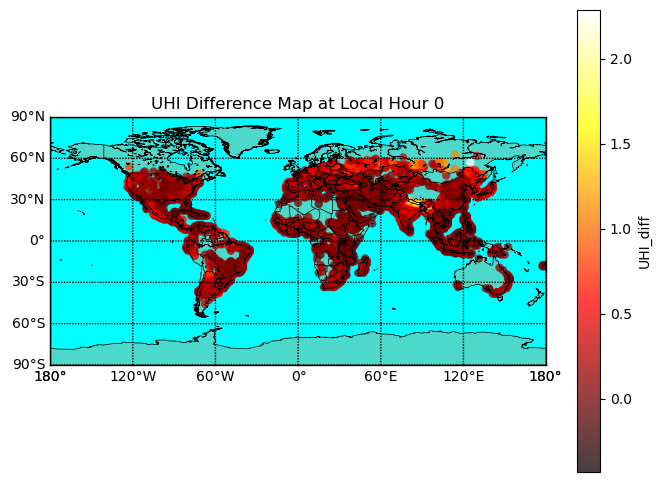

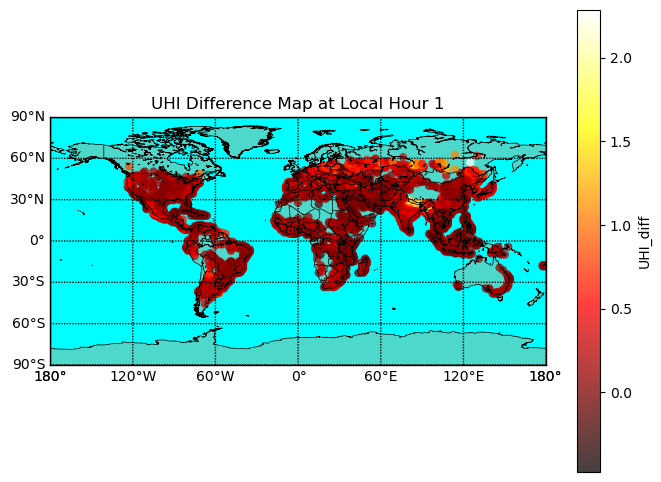

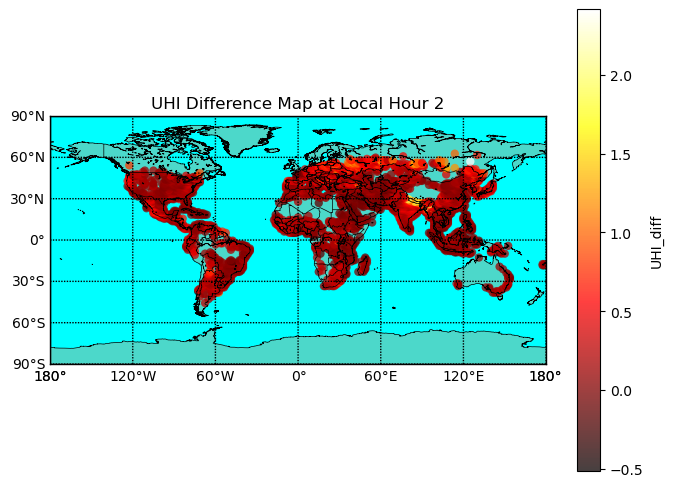

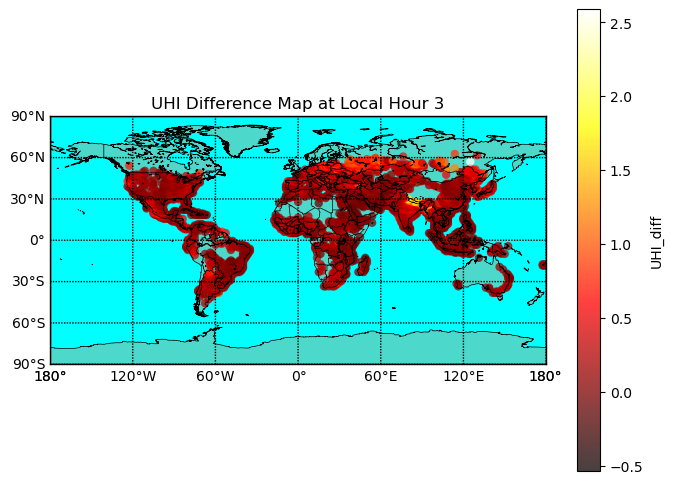

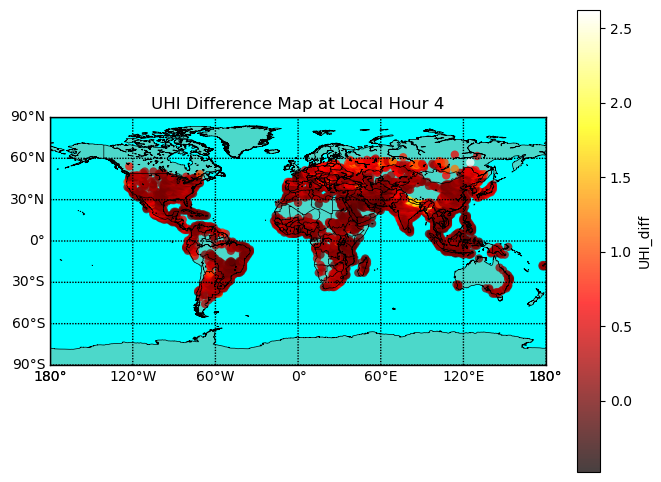

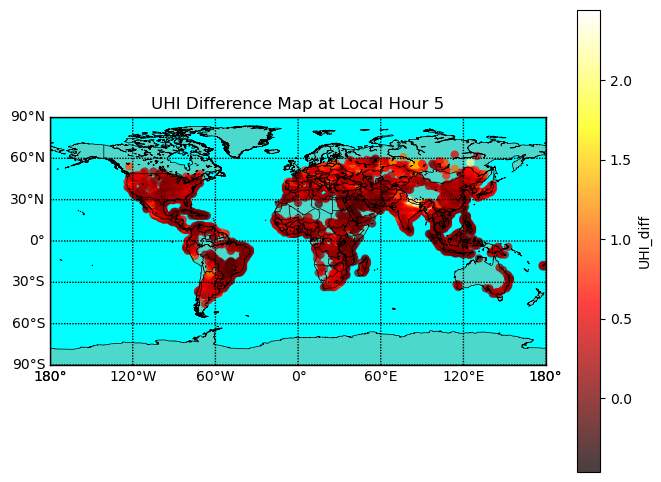

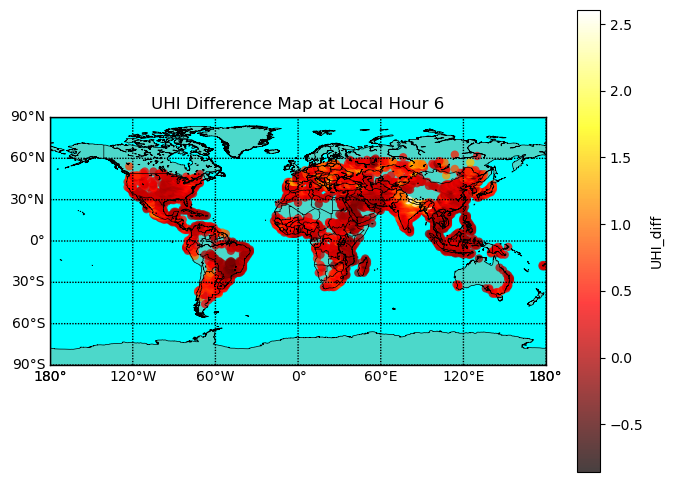

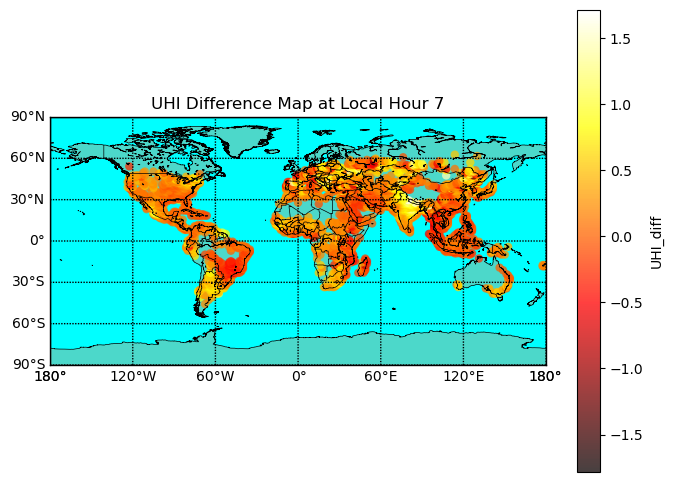

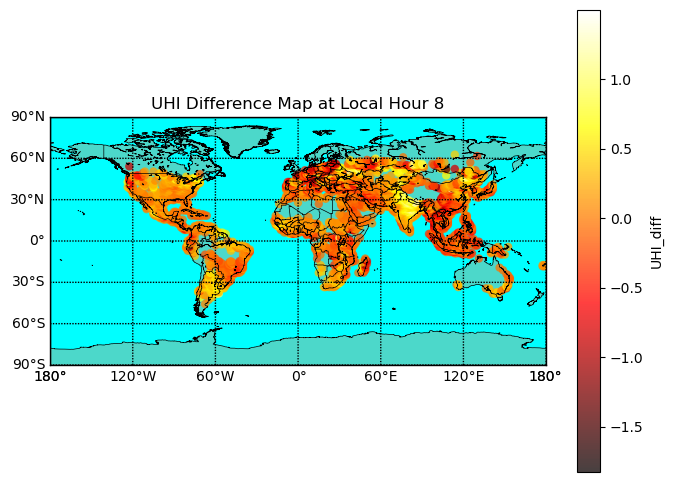

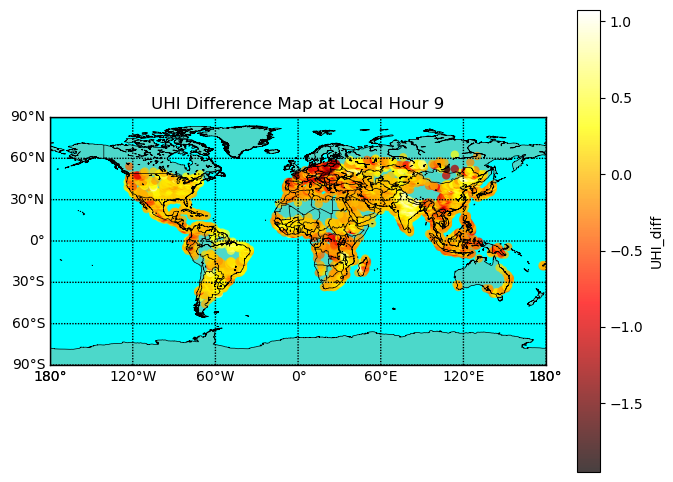

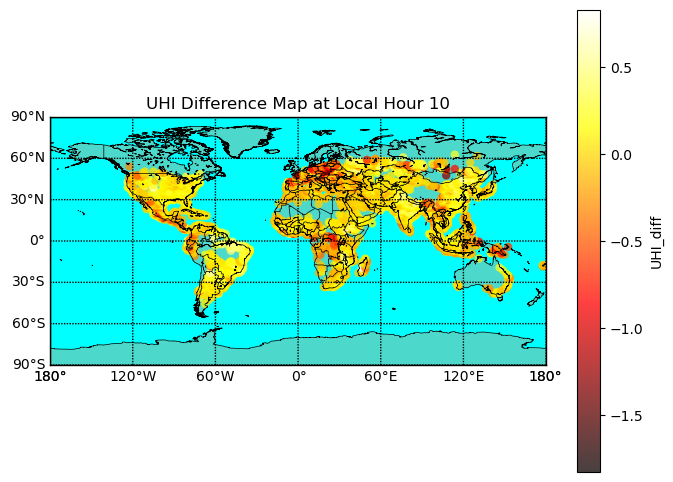

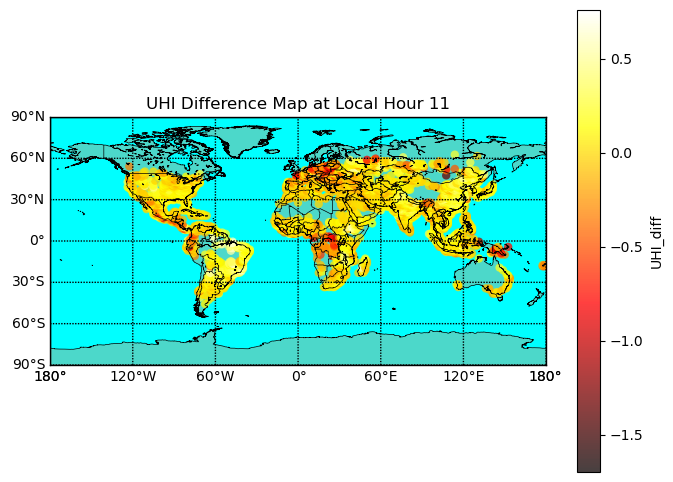

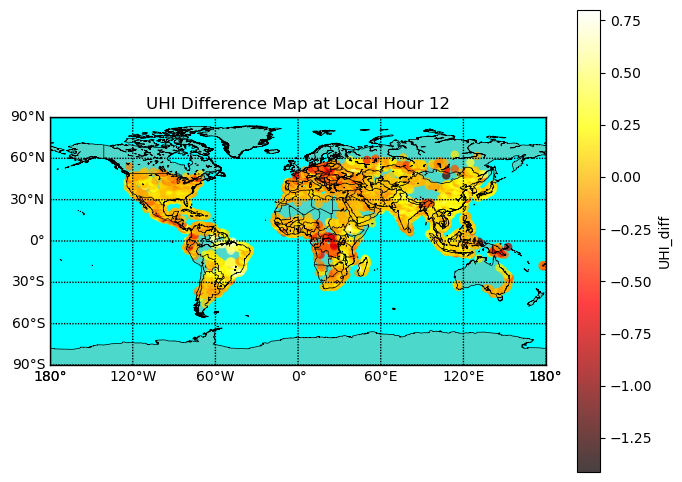

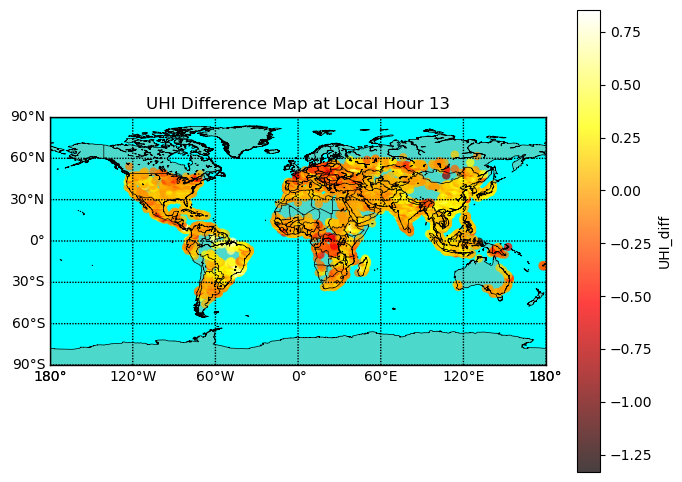

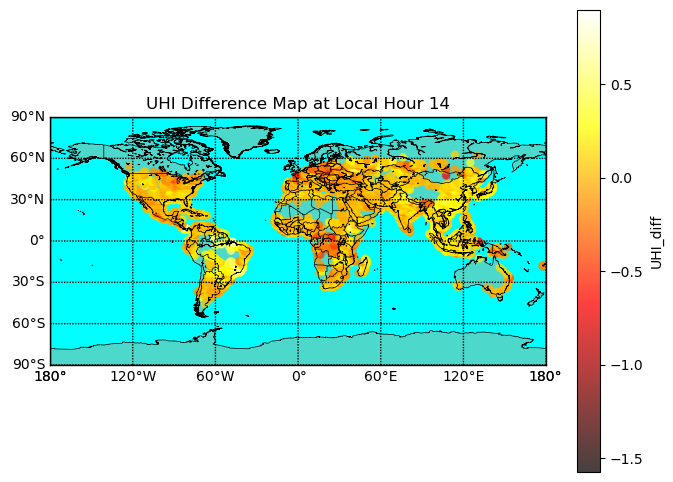

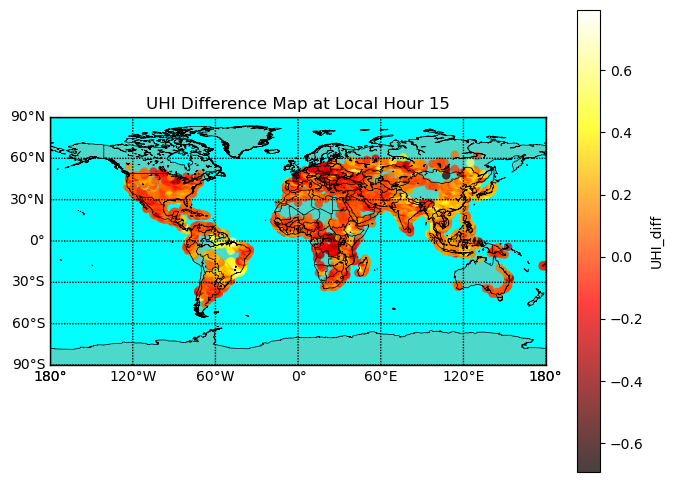

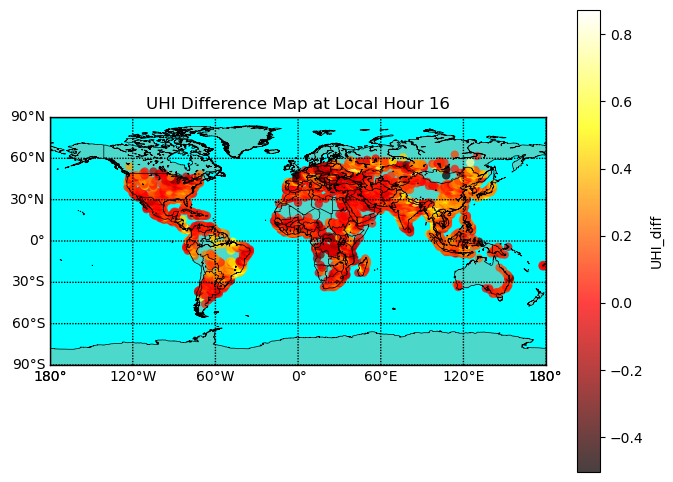

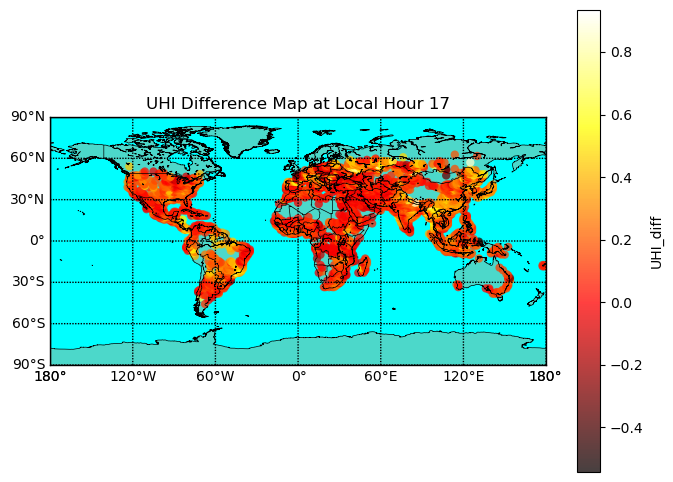

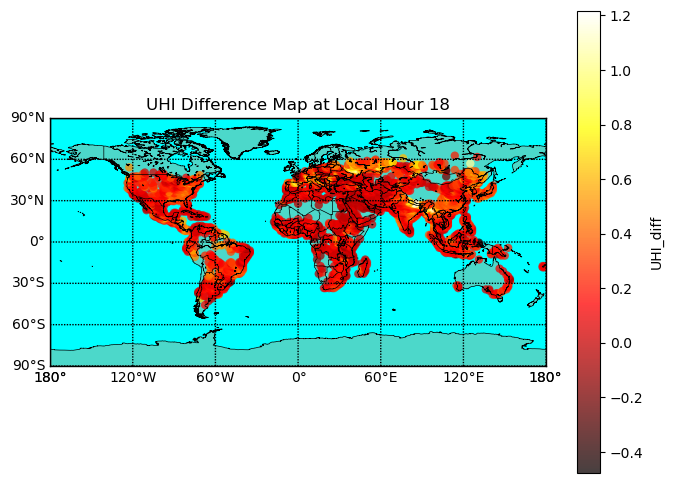

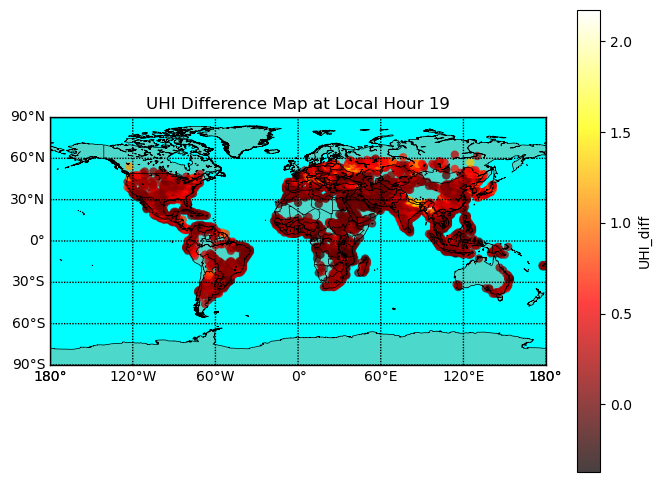

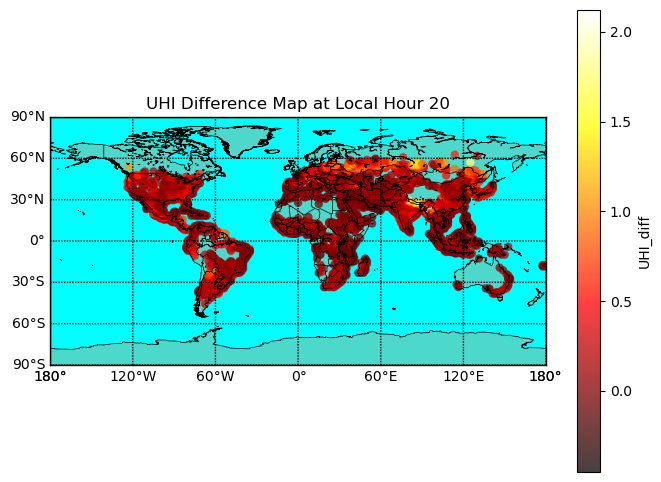

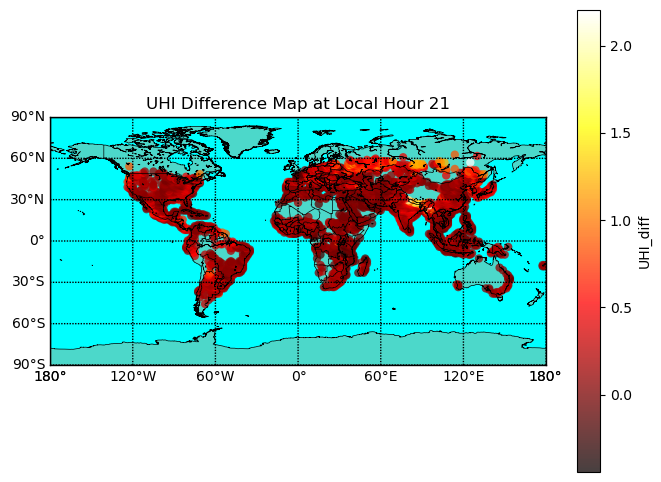

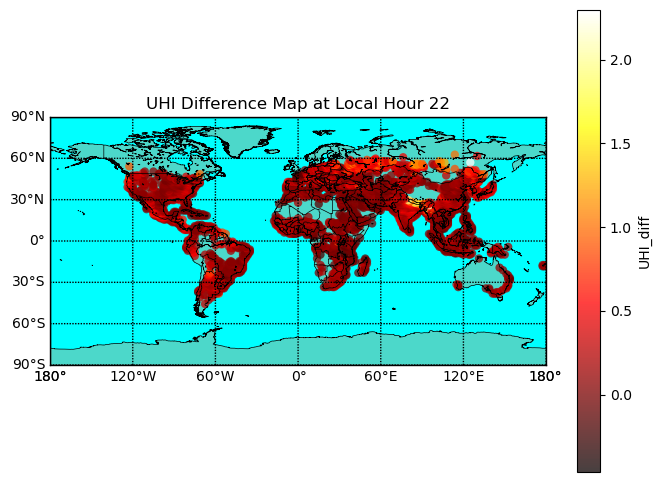

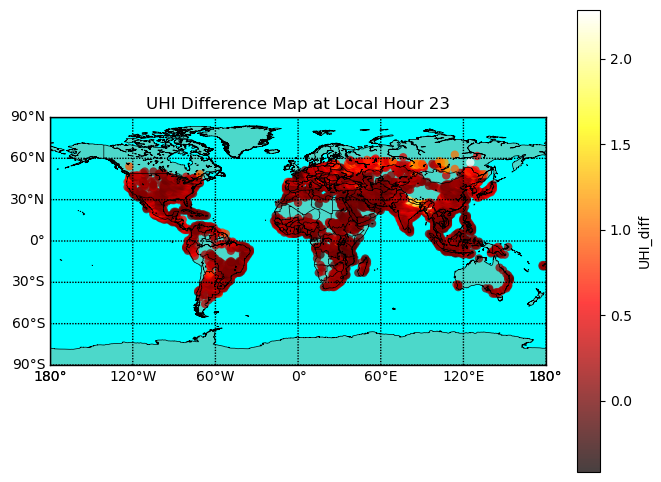

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

# Assuming 'grouped_sorted' is your DataFrame

# Function to normalize longitude values to the range [-180, 180]
def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

# Normalize the longitude values in your DataFrame
grouped_sorted['lon'] = grouped_sorted['lon'].apply(normalize_longitude)

# Define the map drawing function
def draw_map(m, scale=0.2):
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.fillcontinents(color='coral', lake_color='aqua', alpha=0.3)
    m.drawmapboundary(fill_color='aqua')

    # Draw parallels and meridians
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10)

# Iterate through each local_hour to plot maps
for hour in grouped_sorted['local_hour'].unique():
    # Filter data for the current hour
    df_hour = grouped_sorted[grouped_sorted['local_hour'] == hour]

    # Setup the Basemap
    fig = plt.figure(figsize=(8, 6), dpi=100)
    m = Basemap(projection='cyl', resolution='l', lat_0=0, lon_0=0)

    draw_map(m)

    # Scatter UHI_diff data
    x, y = m(df_hour['lon'].values, df_hour['lat'].values)
    sc = m.scatter(x, y, c=df_hour['UHI_diff'], cmap='hot', marker='o', edgecolor='none', alpha=0.75)

    # Add color bar
    plt.colorbar(sc, label='UHI_diff')

    plt.title(f'UHI Difference Map at Local Hour {hour}')
    plt.show()


#  Miscalanous items

In [ ]:
df_count = df_hw.groupby(['lat', 'lon']).size()
df_count

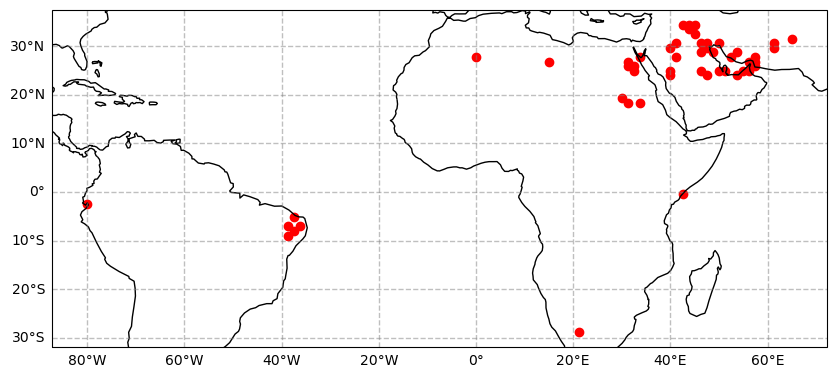

In [21]:
import os


import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df_hw = pd.read_parquet('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet/HW_1985_1994.parquet')
df_count = df_hw.groupby(['lat', 'lon']).size()
df_count_sorted = df_count.sort_values(ascending=False).head(50)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

lats, lons = zip(*df_count_sorted.index)
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()

## group by north south hemisphere

In [33]:
grouped_sorted.groupby(lambda x: (grouped_sorted.loc[x, 'lat'] > 0, grouped_sorted.loc[x, 'local_hour']))['UHI_diff'].mean()

(False, 0)     0.131469
(False, 1)     0.136323
(False, 2)     0.143677
(False, 3)     0.145579
(False, 4)     0.160172
(False, 5)     0.178951
(False, 6)     0.185624
(False, 7)     0.121088
(False, 8)     0.041763
(False, 9)     0.011181
(False, 10)    0.036518
(False, 11)    0.062586
(False, 12)    0.072629
(False, 13)    0.073781
(False, 14)    0.084881
(False, 15)    0.104024
(False, 16)    0.123534
(False, 17)    0.143521
(False, 18)    0.156710
(False, 19)    0.140997
(False, 20)    0.136562
(False, 21)    0.132314
(False, 22)    0.129147
(False, 23)    0.130198
(True, 0)      0.199941
(True, 1)      0.206452
(True, 2)      0.213330
(True, 3)      0.222662
(True, 4)      0.239382
(True, 5)      0.276422
(True, 6)      0.304363
(True, 7)      0.187425
(True, 8)      0.008741
(True, 9)     -0.041449
(True, 10)    -0.013012
(True, 11)     0.010261
(True, 12)     0.025061
(True, 13)     0.031483
(True, 14)     0.046825
(True, 15)     0.074659
(True, 16)     0.109389
(True, 17)     0